## Did you find an interesting article and want to easily find related research without browsing all existing publications yourself? Do you have a specific research question and want to discover relevant articles? Then this notebook might help you.

**Approach**:
We first discover a number of topics using LDA (Latent Dirichlet Allocation). This allows us to view each article as a mixture of these topics. By mapping a specific article into the topic space (a simplex with a topic in each corner), we can then find related articles.


---
### Website now available on [discovid.ai](https://discovid.ai)!
Because of all the positive feedback and the growing interest in this recommendation system, we are now hosting it as a web service to make it more accessible to the broader public!

Check out the following notebook for more information: https://www.kaggle.com/danielwolffram/discovid-ai-a-search-and-recommendation-engine.
We now use a **whoosh search engine** as an initial search that allows complex boolean queries or to search specific fields (title, abstract, authors, journal, doi, methods). This topic model is then used to find related articles.

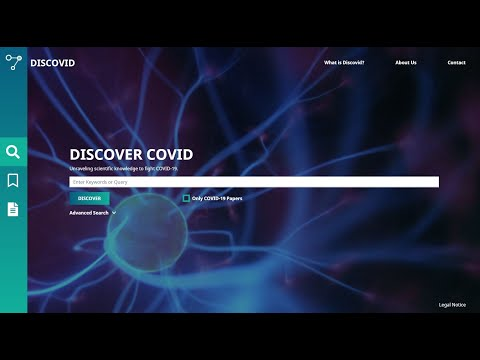

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('ebrPwrBx4cw', width=800, height=450)

___

** Features**
* Similarity measure to show the **confidence** in the recommendations
* Plots that show the **topic-distribution** of an article
* Select a **time range** to limit the articles that are considered (you can decide if you want to find the latest publications or search for insights in past research)
* Option to only suggest **COVID-19-papers** (those that contain COVID-19, SARS-CoV-2, 2019-nCov, SARS Coronavirus 2 or 2019 Novel Coronavirus in the text body)


**Pros**:
* Doesn't only use the title or meta-data, but the actual content (text body) of the articles 
* Once trained, the model is easy and fast to apply
* Helps to discover latent relationships between articles that might drive innovation

**Cons**:
* Unsupervised learning of topics is hard to verify

___


Any feedback or feature requests are welcome! 

![Topic Space](https://inlovewithcode.files.wordpress.com/2017/02/screen-shot-2017-02-27-at-5-35-14-pm.png?w=1032&h=&zoom=2, width=50)

*Topic = Distribution over Words*

*Document = Mixture of Topics*

Reference: https://www.youtube.com/watch?v=3mHy4OSyRf0&t=515s

# Install/Load Packages

*Internet access needs to be switched on for this to work!*

In [2]:
# from IPython.utils import io
# with io.capture_output() as captured:
#     !pip install scispacy
#     !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [2]:
import spacy
import os

In [5]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# import scispacy
# import spacy
# import en_core_sci_lg

import en_core_web_lg

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt

plt.style.use("dark_background")

# Load and Prepare Data

In [9]:
df_1 = pd.read_csv(os.path.join("data", "Fake.csv"))
df_2 = pd.read_csv(os.path.join("data", "True.csv"))

In [13]:
df = pd.concat([df_1, df_2], axis=0)

In [4]:
# df = pd.read_csv('../input/cord-19-create-dataframe/cord19_df.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [16]:
df.shape

(44898, 4)

We consider the text body, but the approach could also be applied to the abstracts only.

In [17]:
# all_texts = df.body_text
all_texts = df.text

In [18]:
# example snippet
all_texts[0][:500]

0    Donald Trump just couldn t wish all Americans ...
0    WASHINGTON (Reuters) - The head of a conservat...
Name: text, dtype: object

# Latend Dirichlet Allocation

For preprocessing we use [scispaCy](https://allenai.github.io/scispacy/), which is a Python package containing [spaCy](https://spacy.io) models for processing biomedical, scientific or clinical text.

In [19]:
# medium model
# nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])

nlp = en_core_web_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 3000000

In [20]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [21]:
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym',
    r'\setlength{\oddsidemargin}{-69pt',  r'\usepackage{upgreek', r'\documentclass[12pt]{minimal'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [12]:
# filepath = '../input/topic-modeling-finding-related-articles/'

Generate files/models if they are not there yet.

In [22]:
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer,
                             min_df=2)

data_vectorized = vectorizer.fit_transform(tqdm(all_texts))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44898/44898 [50:54<00:00, 14.70it/s]


In [23]:
data_vectorized.shape

(44898, 89884)

In [ ]:
# vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000)
# data_vectorized = vectorizer.fit_transform(tqdm(all_texts))

In [ ]:
# data_vectorized.shape # with bigrams: 6428134

# data_vectorized.shape # all 1.2 mio?

<AxesSubplot:ylabel='word'>

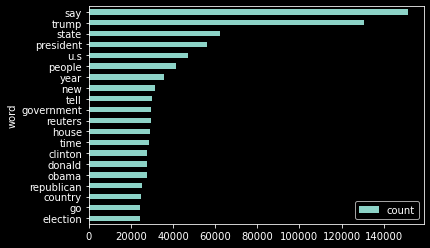

In [24]:
# most frequent words
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [61]:
joblib.dump(vectorizer, 'vectorizer.csv')
joblib.dump(data_vectorized, 'data_vectorized.csv')

['vectorizer_v2.csv']

In [19]:
# if not (isfile(filepath + 'vectorizer.csv') & isfile(filepath + 'data_vectorized.csv')):
#     print('Files not there: generating')
#     vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000)
#     data_vectorized = vectorizer.fit_transform(tqdm(all_texts))
#     joblib.dump(vectorizer, 'vectorizer.csv')
#     joblib.dump(data_vectorized, 'data_vectorized.csv')

# else:
#     vectorizer = joblib.load(filepath + 'vectorizer.csv')
#     data_vectorized = joblib.load(filepath + 'data_vectorized.csv')

In [26]:
lda = LatentDirichletAllocation(n_components=50, random_state=0)
lda.fit(data_vectorized)
joblib.dump(lda, 'lda.csv')

['lda.csv']

In [21]:
# # Train/Load Model
# if not (isfile(filepath + 'lda.csv')):
#     print('File not there: generating')
#     lda = LatentDirichletAllocation(n_components=50, random_state=0)
#     lda.fit(data_vectorized)

#     joblib.dump(lda, 'lda.csv')

# else:
#     lda = joblib.load(filepath + 'lda.csv') 

## Discovered Topics

In [73]:
test = vectorizer.transform(["hello world"])
lda.transform(test)

array([[0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
        0.00666667, 0.67333333, 0.00666667, 0.00666667, 0.00666667]])

In [27]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [28]:
print_top_words(lda, vectorizer, n_top_words=25)


Topic #0: tax percent year pay say rate business cut taxis income plan money budget reform company spend high market fund low increase economic new economy debt

Topic #1: trump poll election clinton percent voter vote say win campaign candidate state hillary support presidential supporter republican donald point party show president democratic lead new

Topic #2: muslim israel muslims state jerusalem say islamic israeli trump unite palestinian president peace islam terrorist east u.s refugee religious world country american capital america christian

Topic #3: republican republicans senate democrat house vote say senator party ryan congress trump democratic leader bill president representative support majority mcconnell lawmaker committee paul election washington

Topic #4: bill say health obamacare plan healthcare fund house insurance care state repeal legislation government law program pass u.s budget congress year act republicans republican people

Topic #5: venezuela maduro say o


Topic #49: black police man white people officer live shoot video say tell old kill violence like post matt time go cop leave take hate child get



Each article is a mixture of topics / a distribution over topics

In [32]:
doc_topic_dist = pd.DataFrame(lda.transform(data_vectorized))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)

In [30]:
# if not (isfile(filepath + 'doc_topic_dist.csv')):
#         print('File not there: generating')
#         doc_topic_dist = pd.DataFrame(lda.transform(data_vectorized))
#         doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)
# else:
#         doc_topic_dist = pd.read_csv(filepath + 'doc_topic_dist.csv')  

In [33]:
doc_topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.095175,...,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083
1,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.085732,0.000118,0.000118,0.000118,...,0.000118,0.000118,0.000118,0.000118,0.000118,0.050572,0.000118,0.000118,0.000118,0.000118
2,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.022097,0.176766,...,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.183994
3,0.042179,0.000099,0.000099,0.000099,0.000099,0.000099,0.000099,0.000099,0.000099,0.039951,...,0.000099,0.051551,0.000099,0.000099,0.000099,0.087527,0.000099,0.000099,0.000099,0.000099
4,0.000106,0.000106,0.439000,0.000106,0.000106,0.000106,0.217865,0.150698,0.000106,0.000106,...,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106


# Get Nearest Papers (in Topic Space)

In [37]:
# is_covid19_article = df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')

In [47]:
# def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2020, only_covid19=False, get_dist=False):
#     '''
#     doc_dist: topic distribution (sums to 1) of one article
    
#     Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
#     '''
    
#     relevant_time = df.publish_year.between(lower, upper)
    
#     if only_covid19:
#         temp = doc_topic_dist[relevant_time & is_covid19_article]
        
#     else:
#         temp = doc_topic_dist[relevant_time]
         
#     distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
#     k_nearest = distances[distances != 0].nsmallest(n=k).index
    
#     if get_dist:
#         k_distances = distances[distances != 0].nsmallest(n=k)
#         return k_nearest, k_distances
#     else:
#         return k_nearest
    
def get_k_nearest_docs(doc_dist, k=5, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
         
    distances = doc_topic_dist.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

In [39]:
# d = get_k_nearest_docs(doc_topic_dist[df.paper_id == '90b5ecf991032f3918ad43b252e17d1171b4ea63'].iloc[0])

# sb.kdeplot(d)

In [48]:
def plot_article_dna(paper_id, width=20):
    t = df[df.paper_id == paper_id].title.values[0]
    doc_topic_dist[df.paper_id == paper_id].T.plot(kind='bar', legend=None, title=t, figsize=(width, 4))
    plt.xlabel('Topic')

def compare_dnas(paper_id, recommendation_id, width=20):
    t = df[df.paper_id == recommendation_id].title.values[0]
    temp = doc_topic_dist[df.paper_id == paper_id]
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, doc_topic_dist[df.paper_id == recommendation_id]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])

# compare_dnas('90b5ecf991032f3918ad43b252e17d1171b4ea63', 'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a')

def dna_tabs(paper_ids):
    k = len(paper_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = plot_article_dna(paper_ids[i])
            plt.show(ax)

def compare_tabs(paper_id, recommendation_ids):
    k = len(recommendation_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = compare_dnas(paper_id, recommendation_ids[i])
            plt.show(ax)

# Search related papers to a chosen one

As a similarity measure we use 1 - Jensen-Shannon distance.

In [44]:
doc_topic_dist

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.095175,...,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083,0.000083
1,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.085732,0.000118,0.000118,0.000118,...,0.000118,0.000118,0.000118,0.000118,0.000118,0.050572,0.000118,0.000118,0.000118,0.000118
2,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.022097,0.176766,...,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.183994
3,0.042179,0.000099,0.000099,0.000099,0.000099,0.000099,0.000099,0.000099,0.000099,0.039951,...,0.000099,0.051551,0.000099,0.000099,0.000099,0.087527,0.000099,0.000099,0.000099,0.000099
4,0.000106,0.000106,0.439000,0.000106,0.000106,0.000106,0.217865,0.150698,0.000106,0.000106,...,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,...,0.066573,0.000082,0.000082,0.012988,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082
44894,0.000274,0.000274,0.000274,0.000274,0.000274,0.000274,0.000274,0.000274,0.000274,0.124116,...,0.219604,0.000274,0.000274,0.284823,0.000274,0.000274,0.000274,0.000274,0.000274,0.000274
44895,0.064991,0.000131,0.000131,0.000131,0.000131,0.000131,0.000131,0.000131,0.000131,0.000131,...,0.157237,0.000131,0.032764,0.019951,0.167260,0.000131,0.000131,0.000131,0.000131,0.000131
44896,0.000190,0.000190,0.072799,0.000190,0.000190,0.039362,0.000190,0.301768,0.000190,0.000190,...,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190


In [59]:
def recommendation(idx, k=5, plot_dna=False):
    '''
    Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
    '''
    
    print(df.iloc[idx].values[0])

    recommended, dist = get_k_nearest_docs(doc_topic_dist.iloc[idx], k, get_dist=True)
    recommended = df.iloc[recommended].copy()
    recommended['similarity'] = 1 - dist 
    
    
    for t, d, s in recommended[['title', 'date', 'similarity']].values:
        print(f"\n{t} ({d}), similarity - {s}")
    

# def recommendation(paper_id, k=5, lower=1950, upper=2020, only_covid19=False, plot_dna=False):
#     '''
#     Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
#     '''
    
#     print(df.title[df.paper_id == paper_id].values[0])

#     recommended, dist = get_k_nearest_docs(doc_topic_dist[df.paper_id == paper_id].iloc[0], k, lower, upper, only_covid19, get_dist=True)
#     recommended = df.iloc[recommended].copy()
#     recommended['similarity'] = 1 - dist 
    
#     h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['url','title', 'similarity']].values])
#     display(HTML(h))
    
#     if plot_dna:
#         compare_tabs(paper_id, recommended.paper_id.values)

In [77]:
df.to_csv("topic_modeling_df.csv", index=False)

In [78]:
pd.read_csv("topic_modeling_df.csv")

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [60]:
recommendation(idx=0, k=5, plot_dna=True)

 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing

 The ‘Fake Melania Trump’ Conspiracy Theory Is Taking The Internet By Storm And It’s Everything (October 18, 2017), similarity - 0.7588017895605002

 WATCH: Kathy Griffin PERFECTLY Responds To Trump’s Insults Toward Women (October 19, 2016), similarity - 0.7547581844425183

 The Internet HILARIOUSLY Mocks Trump With #TinyTrump Memes, Trump Hissy Fit In 3..2..1.. (IMAGES) (February 18, 2017), similarity - 0.7502621839168332

 WATCH: Colbert HILARIOUSLY Portrays Trump As A Little Girl And The Internet Is Laughing Out Loud (February 11, 2017), similarity - 0.7454231289970499

 Donald Trump Jr Tweets Unintentionally Humiliating Photo, Blocks People Who Mock Him (April 15, 2017), similarity - 0.739793787476267


The effect of inhibition of PP1 and TNFα signaling on pathogenesis of SARS coronavirus


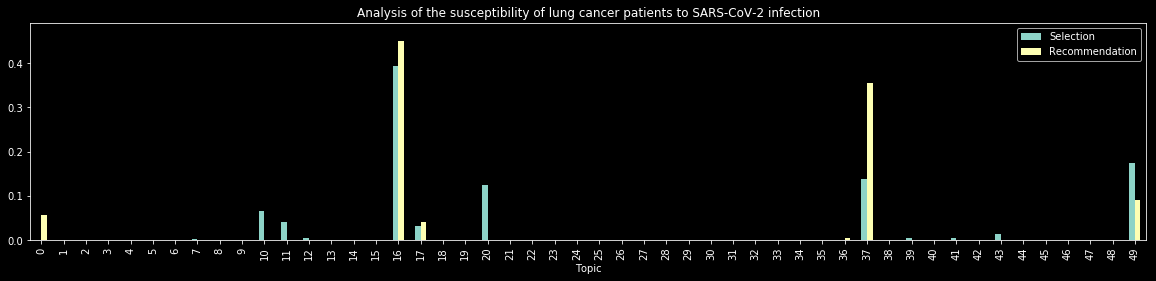

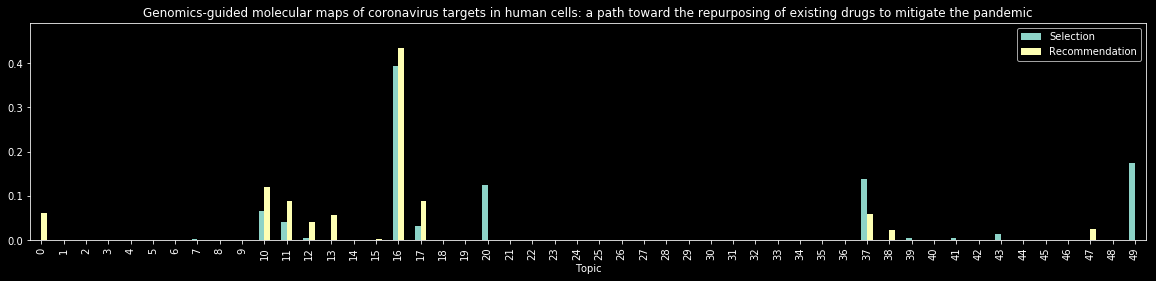

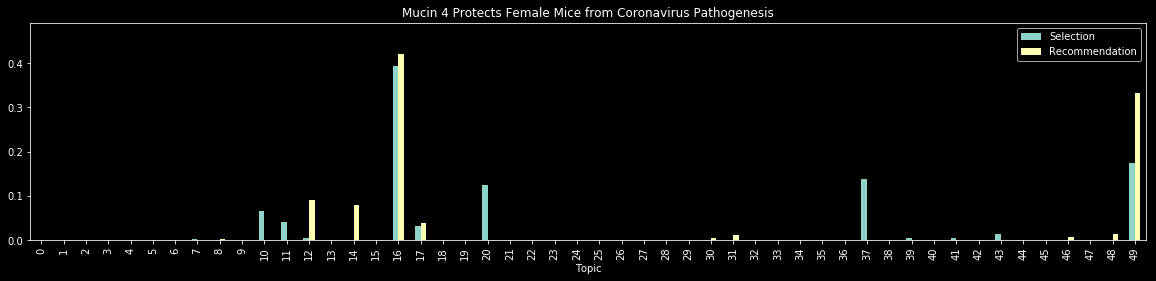

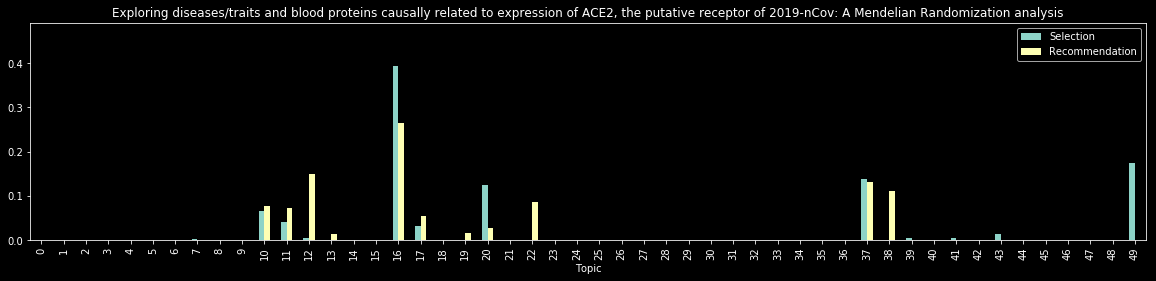

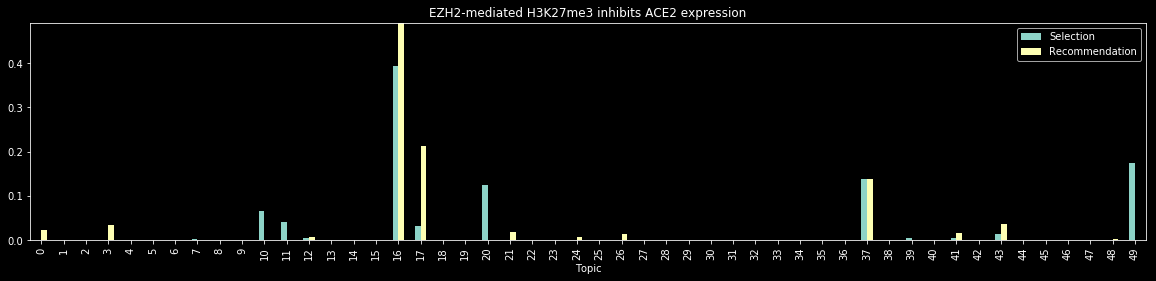

In [33]:
# recommendation('a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a', k=5, only_covid19=True, plot_dna=True)

The role of absolute humidity on transmission rates of the COVID-19 outbreak


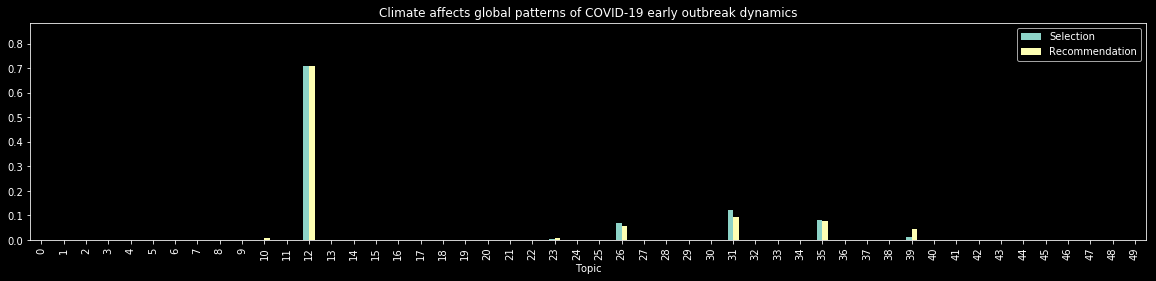

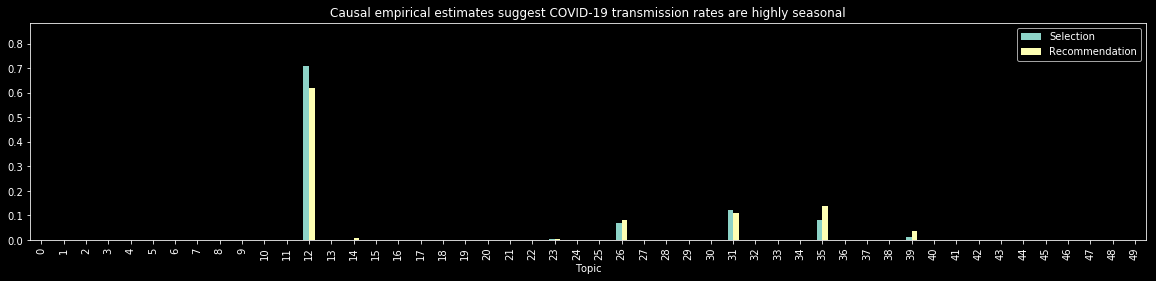

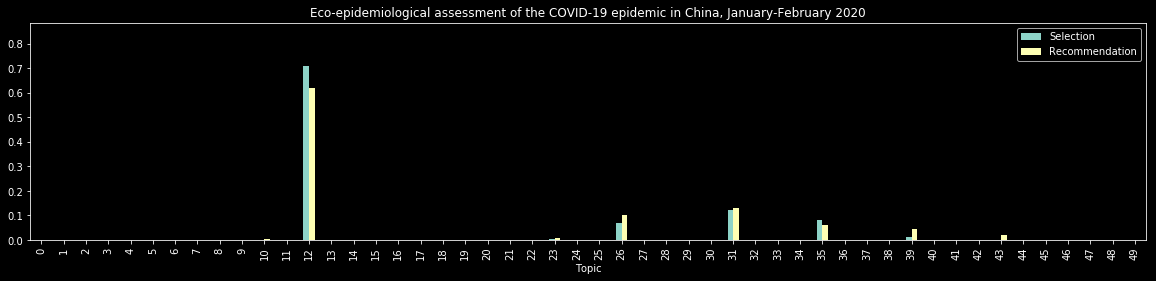

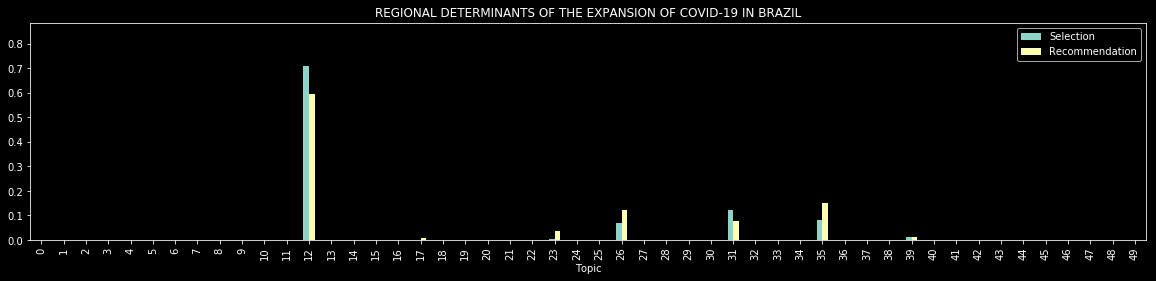

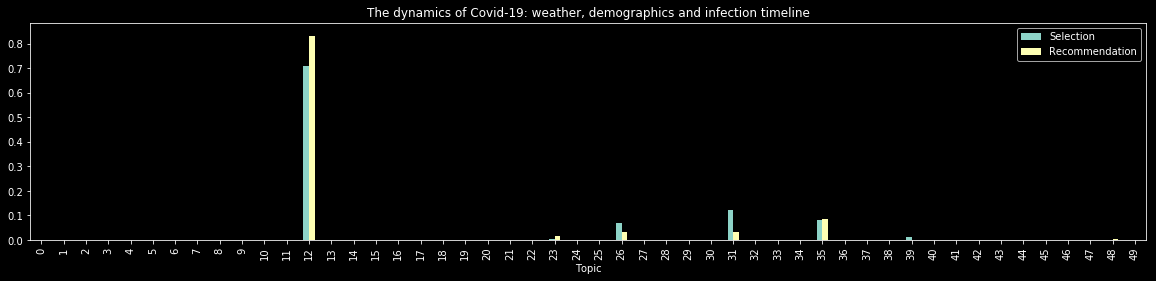

In [34]:
# recommendation('90b5ecf991032f3918ad43b252e17d1171b4ea63', k=5, only_covid19=False, plot_dna=True)

Potential inhibitors for 2019-nCoV coronavirus M protease from clinically approved medicines


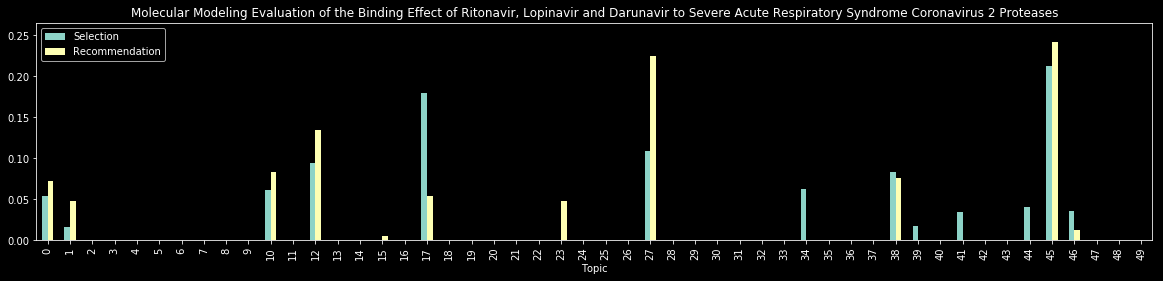

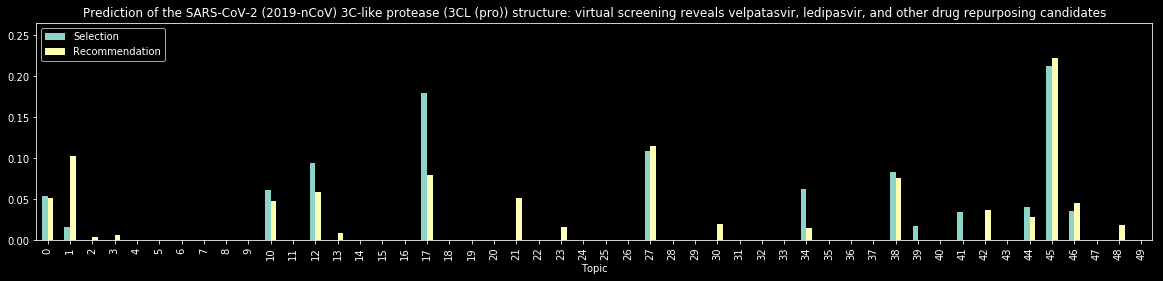

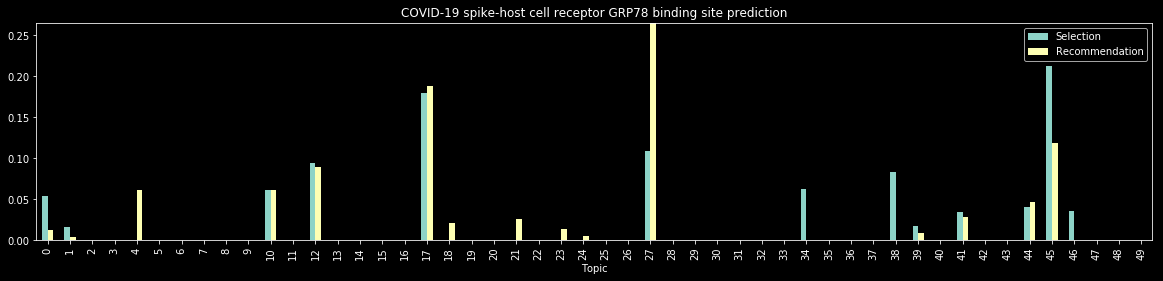

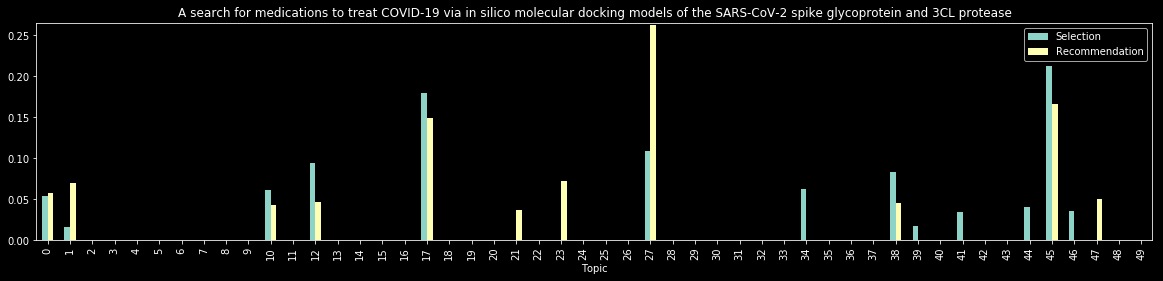

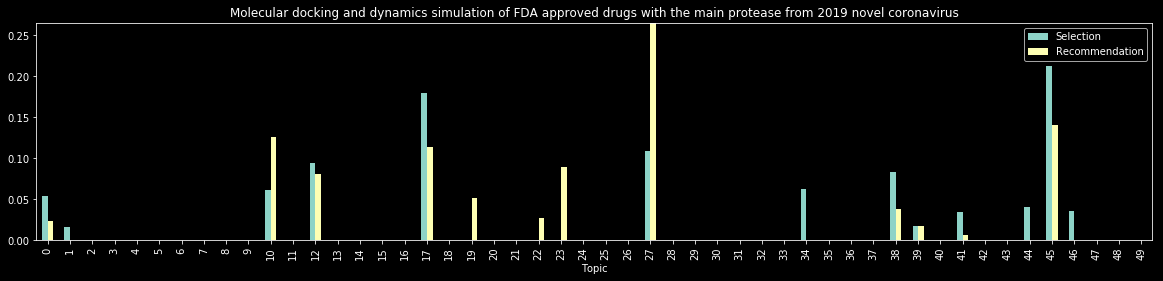

In [35]:
recommendation('c04c7fb330a409a00f67040dde0f83b3da88eacb', k=5, only_covid19=True, plot_dna=True)

In [36]:
recommendation('36521caf90f471c9da1a4e84f8562440d73ead9a', k=5, plot_dna=True)

Estimation of the epidemic properties of the 2019 novel coronavirus: A mathematical modeling study


TypeError: must be str, not float

# Widget: Pick a COVID-19-Paper 

This makes it easier to pick a paper (you don't have to search the paper_id).

In [37]:
def related_papers():
    '''
    Creates a widget where you can select one of many papers about covid-19 and then displays related articles from the whole dataset.
    '''
    covid_papers = df[df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')][['paper_id', 'title']] # are there more names?
    title_to_id = covid_papers.set_index('title')['paper_id'].to_dict()
    
    def main_function(bullet, k=5, year_range=[1950, 2020], only_covid19=False):
        recommendation(title_to_id[bullet], k, lower=year_range[0], upper=year_range[1], only_covid19=only_covid19)
    
    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                                   continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=False,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='20%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='20%'))

    bulletW = widgets.Select(options=title_to_id.keys(), layout=Layout(width='90%', height='200px'), description='Title:')

    widget = widgets.interactive(main_function, bullet=bulletW, k=kWidget, year_range=yearW, only_covid19=covidW)

    controls = VBox([Box(children=[widget.children[:-1][1], widget.children[:-1][2], widget.children[:-1][3]], 
                         layout=Layout(justify_content='space-around')), widget.children[:-1][0]])
    output = widget.children[-1]
    display(VBox([controls, output]))

In [38]:
related_papers()

TraitError: Invalid selection: value not found

# Browse Tasks

We can now also map a task or bullet point into the topic space and find related articles that might help to solve the question at hand.

Note: Some of the bullet points are very short - results might not be reliable in this case.  

In [39]:
task1 = ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.",
"Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
"Seasonality of transmission.",
"Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
"Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
"Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
"Natural history of the virus and shedding of it from an infected person",
"Implementation of diagnostics and products to improve clinical processes",
"Disease models, including animal models for infection, disease and transmission",
"Tools and studies to monitor phenotypic change and potential adaptation of the virus",
"Immune response and immunity",
"Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
 "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
"Role of the environment in transmission"]

task2 = ['Data on potential risks factors',
'Smoking, pre-existing pulmonary disease',
'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities',
'Neonates and pregnant women',
'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors', 
'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups',
'Susceptibility of populations',
'Public health mitigation measures that could be effective for control']

task3 = ['Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.',
'Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.',
'Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.',
'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.',
'Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.',
'Experimental infections to test host range for this pathogen.',
'Animal host(s) and any evidence of continued spill-over to humans',
'Socioeconomic and behavioral risk factors for this spill-over',
'Sustainable risk reduction strategies']

task4 = ["Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
"Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
"Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
"Methods to control the spread in communities, barriers to compliance and how these vary among different populations..",
"Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
"Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
"Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
"Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."]

task5 = ["Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
"Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
"Exploration of use of best animal models and their predictive value for a human vaccine.",
"Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
"Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
"Efforts targeted at a universal coronavirus vaccine.",
"Efforts to develop animal models and standardize challenge studies",
"Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
"Approaches to evaluate risk for enhanced disease after vaccination",
"Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]"]

task6 = ["Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019", 
"Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
"Efforts to support sustained education, access, and capacity building in the area of ethics",
"Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
"Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
"Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.",
"Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."]

task7 = ["How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
"Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
"Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
"National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
"Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
"Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
"Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
"Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
"Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
"Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
"Policies and protocols for screening and testing.",
"Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
"Technology roadmap for diagnostics.",
"Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
"New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
"Coupling genomics and diagnostic testing on a large scale.",
"Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
"Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
"One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."]

task8 = ["Resources to support skilled nursing facilities and long term care facilities.",
"Mobilization of surge medical staff to address shortages in overwhelmed communities",
"Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
"Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
"Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
"Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
"Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
"Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
"Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
"Guidance on the simple things people can do at home to take care of sick people and manage disease.",
"Oral medications that might potentially work.",
"Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
"Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
"Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
"Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
"Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"]

task9 = ["Methods for coordinating data-gathering with standardized nomenclature.",
"Sharing response information among planners, providers, and others.",
"Understanding and mitigating barriers to information-sharing.",
"How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
"Integration of federal/state/local public health surveillance systems.",
"Value of investments in baseline public health response infrastructure preparedness",
"Modes of communicating with target high-risk populations (elderly, health care workers).",
"Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
"Communication that indicates potential risk of disease to all population groups.",
"Misunderstanding around containment and mitigation.",
"Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
"Measures to reach marginalized and disadvantaged populations.",
"Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
"Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
"Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"]

tasks={'What is known about transmission, incubation, and environmental stability?': task1,
       'What do we know about COVID-19 risk factors?': task2, 
       'What do we know about virus genetics, origin, and evolution?': task3, 
       'What do we know about non-pharmaceutical interventions?': task4,
       'What do we know about vaccines and therapeutics?': task5, 
       'What has been published about ethical and social science considerations?': task6, 
       'What do we know about diagnostics and surveillance?': task7,
       'What has been published about medical care?': task8, 
       'What has been published about information sharing and inter-sectoral collaboration?': task9}

In [40]:
# def relevant_articles(tasks, k=3, lower=1950, upper=2020, only_covid19=False):
#     tasks = [tasks] if type(tasks) is str else tasks 
    
#     tasks_tf = tf_vectorizer.transform(tasks)
#     tasks_topic_dist = pd.DataFrame(lda_tf.transform(tasks_tf))

#     for index, bullet in enumerate(tasks):
#         print(bullet)
#         recommended = get_k_nearest_docs(tasks_topic_dist.iloc[index], k, lower, upper, only_covid19)
#         recommended = all_data.iloc[recommended]

#         recommended[['paper_id','title', 'abstract']].to_csv('task' + str(index) + '.csv')

In [41]:
def relevant_articles(tasks, k=3, lower=1950, upper=2020, only_covid19=False):
    tasks = [tasks] if type(tasks) is str else tasks 
    
    tasks_vectorized = vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(lda.transform(tasks_vectorized))

    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended = get_k_nearest_docs(tasks_topic_dist.iloc[index], k, lower, upper, only_covid19)
        recommended = df.iloc[recommended]

        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' for l, n in recommended[['url','title']].values])
        display(HTML(h))

## What is known about transmission, incubation, and environmental stability?

In [42]:
relevant_articles(task1, 5, only_covid19=True)

Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.


Prevalence of asymptomatic shedding and transmission (e.g., particularly children).


Seasonality of transmission.


Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).


TypeError: must be str, not float

## What do we know about COVID-19 risk factors?

In [43]:
relevant_articles(task2, 5, only_covid19=True)

Data on potential risks factors


Smoking, pre-existing pulmonary disease


Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities


Neonates and pregnant women


Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.


Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors


Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups


Susceptibility of populations


TypeError: must be str, not float

## What do we know about virus genetics, origin, and evolution?

In [44]:
relevant_articles(task3, 5, only_covid19=True)

Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.


Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.


TypeError: must be str, not float

## What do we know about non-pharmaceutical interventions?

In [45]:
relevant_articles(task4, 5, only_covid19=True)

Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.


Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.


Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.


Methods to control the spread in communities, barriers to compliance and how these vary among different populations..


Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.


Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.


Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).


Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay.


## What do we know about vaccines and therapeutics?

In [46]:
relevant_articles(task5, 5, only_covid19=True)

Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.


Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.


Exploration of use of best animal models and their predictive value for a human vaccine.


Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.


Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.


Efforts targeted at a universal coronavirus vaccine.


Efforts to develop animal models and standardize challenge studies


Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers


Approaches to evaluate risk for enhanced disease after vaccination


Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]


## What has been published about ethical and social science considerations?

In [47]:
relevant_articles(task6, 5, only_covid19=True)

Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019


Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight


Efforts to support sustained education, access, and capacity building in the area of ethics


Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.


Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)


Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.


Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media.


## What do we know about diagnostics and surveillance?

In [48]:
relevant_articles(task7, 5, only_covid19=True)

How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).


Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.


Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.


National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).


Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.


Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).


Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.


Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.


Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.


Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.


Policies and protocols for screening and testing.


Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.


Technology roadmap for diagnostics.


Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.


New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.


Coupling genomics and diagnostic testing on a large scale.


Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.


Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.


One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors.


## What has been published about medical care?

In [49]:
relevant_articles(task8, 5, only_covid19=True)

Resources to support skilled nursing facilities and long term care facilities.


Mobilization of surge medical staff to address shortages in overwhelmed communities


Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies


Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients


Outcomes data for COVID-19 after mechanical ventilation adjusted for age.


Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.


Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.


Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.


Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.


Guidance on the simple things people can do at home to take care of sick people and manage disease.


Oral medications that might potentially work.


Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.


Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.


Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials


Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials


TypeError: must be str, not float

## What has been published about information sharing and inter-sectoral collaboration?

In [50]:
relevant_articles(task9, 5, only_covid19=True)

Methods for coordinating data-gathering with standardized nomenclature.


TypeError: must be str, not float

# Widget: Pick a Task

Here you can easily pick a bullet point of one of the tasks and see some related articles.

In [51]:
def relevant_articles_for_task():
    def main_function(bullet, task, k=5, year_range=[1950, 2020], only_covid19=False):
        relevant_articles([bullet], k, lower=year_range[0], upper=year_range[1], only_covid19=only_covid19)
        bulletW.options = tasks[task]    

    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                                   continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='20%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='30%'))

    taskW = widgets.Dropdown(options=tasks.keys(), layout=Layout(width='90%', height='50px'), description='Task:')
    init = taskW.value
    bulletW = widgets.Select(options=tasks[init], layout=Layout(width='90%', height='200px'), description='Bullet Point:')

    widget = widgets.interactive(main_function, task=taskW, bullet=bulletW, k=kWidget, year_range=yearW, only_covid19=covidW)
    
    controls = VBox([HBox([widget.children[2], widget.children[3], widget.children[4]], layout=Layout(width='90%', justify_content='space-around')),
                     widget.children[1],
                     widget.children[0]], layout=Layout(align_items='center'))
    
    output = widget.children[-1]
    display(VBox([controls, output]))

In [52]:
relevant_articles_for_task()

# Widget: Free Text Search

In this widget you can insert any kind of text (abstract, paragraph, full text, keywords, questions, ...) and find related articles.

In [53]:
def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                               continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='25%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1], covidW.value)

    button.on_click(on_button_clicked)

In [54]:
relevant_articles_for_text()